## Developing a 'radar wetlands insight tool'

Setup and imports - note dependencies on other DEA scripts

In [1]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting, TasseledCapTools, wetlands_insight

In [2]:
#setup radar dc
dc = datacube.Datacube(config='radar.conf')
#optical datacube - the radar one is separate and does not duplicate the Landsat archive
dcO = datacube.Datacube()

In [3]:
#load SAR data
#define the time period
qtime = ('2016-09-01', '2019-06-01')

query = {
         'time': qtime,
         'lat': (-12.70,-12.64),
         'long': (132.53,132.64)
         }

#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
#mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
#                                           out_shape=sardata.geobox.shape,
#                                           transform=sardata.geobox.affine,
#                                           all_touched=False,
#                                           invert=False)
#clean=clean.where(~mask)

#drop scenes with a lot of NaN pixels
nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

clean = clean.sel(time = valtimes)

#'vh_over_vv' channel
clean['vh_over_vv'] = clean.vh/clean.vv

#Take the natural logarithm of the backscatter to improve differentiation of dark areas
logclean = np.log(clean)

In [4]:
wit_arr = wetlands_insight.WIT_array(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [5]:
import imp
imp.reload(wetlands_insight)

<module 'wetlands_insight' from './10_Scripts/wetlands_insight.py'>

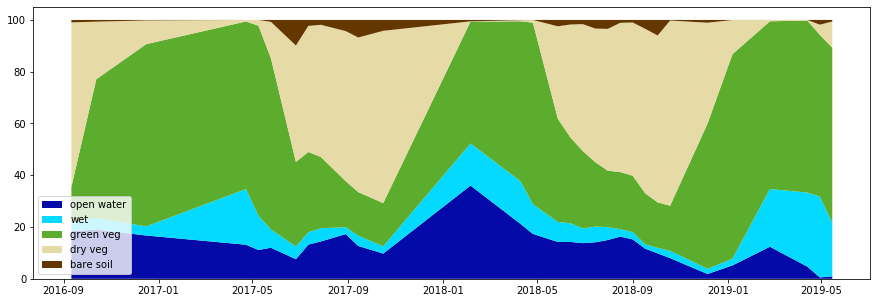

In [6]:
import seaborn as sns

plt.subplots(1,1,figsize=(15,5))

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

plt.stackplot(wit_arr.time.data,wit_arr.to_array().data,labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal)

plt.legend(loc='lower left')

In [7]:
import radar_gmm as rg

In [12]:
kmm = rg.fit_kmeans(logclean.isel(time=-25),n_components=4)

In [13]:
#multiprocessing routine to speed up the timeseries calculation
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())

index_stops = np.linspace(0,len(clean.time),num=mp.cpu_count()+1,dtype=int)

results = [pool.apply_async(rg.calc_gmm_timeseries,args=(logclean,kmm),kwds={'tmin':index_stops[i],'tmax':index_stops[i+1]}) for i in range(len(index_stops) - 1)]

pool.close()
pool.join()

res_a = [r.get() for r in results]

t = xr.concat([res[0] for res in res_a],dim='time')
ts = np.concatenate(tuple(res[1] for res in res_a))

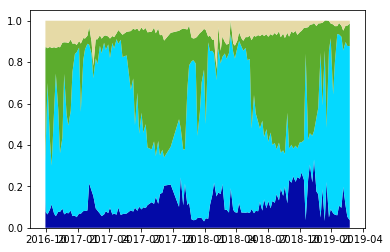

In [14]:
plt.stackplot(t.data,ts.transpose(),colors=pal)

In [15]:
kmm.cluster_centers_

array([[-3.0932329, -4.826994 , -1.7337586],
       [-1.9561367, -3.3840506, -1.4279152],
       [-2.595488 , -4.057222 , -1.4617344],
       [-5.052925 , -6.006082 , -0.9531549]], dtype=float32)

In [16]:
imp.reload(wetlands_insight)

<module 'wetlands_insight' from './10_Scripts/wetlands_insight.py'>

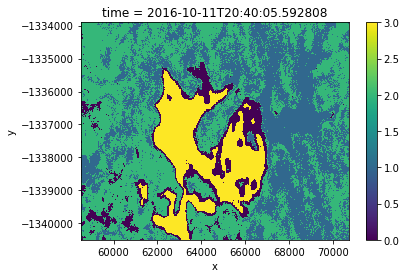

In [20]:
rg.plot_gmm_classes(logclean.isel(time=3),kmm)

By inspection of cotemporal SAR-KMM and WIT classifier images, we can make the following correspondences:

| Name | SAR class | WIT class |
| --- | --- | --- |
| open water | 0 | 0 |
| 'wet' | 3 | 1 |
| PV/'green' | 2 | 3 |
| NPV/'beige' | 1 | 4 |

Class pickup is far from perfect, but hopefully will give a good idea of what is going on in the wetland on a seasonal, whole-scene scale. Note that class 2 (bare soil) in the WIT is almost totally missing in this region and so has no corresponding SAR-KMM class.

The SAR class numbers may vary based on the stochastic initial parameters of the KMM, so it helps to sort the cluster centres in some way to assign consistent labels to the classes. We could do this, for example, in terms of the norm of the cluster centre vectors. Let's do this now.

In [21]:
kmm.cluster_centers_

array([[-3.0932329, -4.826994 , -1.7337586],
       [-1.9561367, -3.3840506, -1.4279152],
       [-2.595488 , -4.057222 , -1.4617344],
       [-5.052925 , -6.006082 , -0.9531549]], dtype=float32)

In [22]:
kmm.cluster_centers_ = kmm.cluster_centers_[np.argsort(-np.linalg.norm(kmm.cluster_centers_,axis=1))]

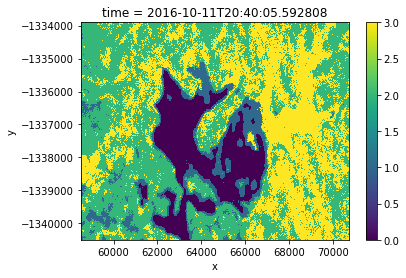

In [23]:
rg.plot_gmm_classes(logclean.isel(time=3),kmm)

The class table now looks like this and should be consistent between runs of the clustering algorithm, at least in this region:

| Name | SAR class | WIT class |
| --- | --- | --- |
| open water | 0 | 0 |
| 'wet' | 1 | 1 |
| PV/'green' | 3 | 3 |
| NPV/'beige' | 2 | 4 |

Unfortunately the ordering of green and beige veg classes needs to be the same so we can directly compare the stack plots between SAR and optical analysis. We can fix this simply by a hard reindexing of the cluster centre array:

In [24]:
kmm.cluster_centers_ = kmm.cluster_centers_[[0,1,3,2]]

Now let's make the stack plot and compare the SAR classes to the WIT ones over time.

In [119]:
imp.reload(rg)

<module 'radar_gmm' from '/g/data1a/r78/rlt118/dea-notebooks/radar_gmm.py'>

In [120]:
import multiprocessing as mp

In [121]:
#calc the timeseries with the new KMM clusters
pool = mp.Pool(mp.cpu_count())

index_stops = np.linspace(0,len(bulknormSAR.time),num=mp.cpu_count()+1,dtype=int)

results = [pool.apply_async(rg.calc_gmm_timeseries,args=(bulknormSAR,kmm),kwds={'tmin':index_stops[i],'tmax':index_stops[i+1], 'subcluster_model':subgmm}) for i in range(len(index_stops) - 1)]

pool.close()
pool.join()

res_a = [r.get() for r in results]

t = xr.concat([res[0] for res in res_a],dim='time')
ts = np.concatenate(tuple(res[1] for res in res_a))

In [101]:
epsg3577 = geometry.CRS('EPSG:3577')
DEADataHandling.write_your_netcdf(landcover_out,'cover_classes',"mamukala.nc",epsg3577)

In [103]:
bulknormSAR.time.attrs

OrderedDict([('units', 'seconds since 1970-01-01 00:00:00')])

In [96]:
landcover_out.time.attrs['units']=allSAR.time.attrs['units']
landcover_out.x.attrs['units']=allSAR.x.attrs['units']
landcover_out.y.attrs['units']=allSAR.y.attrs['units']

In [35]:
#the optical data covers a longer time period than the SAR so let's truncate it
wit_arr = wit_arr.sel(time=slice(t[0],t[-1]))

fig,ax = plt.subplots(2,1,figsize=(15,10))

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

plt.sca(ax[0])
plt.stackplot(wit_arr.time.data,wit_arr.to_array().data,labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal)

plt.legend(loc='lower left')

plt.sca(ax[1])
plt.stackplot(t.data,ts.transpose(),labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg'
                     ], colors=pal)

plt.legend(loc='lower left')

NameError: name 't' is not defined

## Gridded images

In [8]:
#put all the nasty loading and filtering code for the SAR scenes in a simple-to-use function.

def load_cleaned_SAR(query):

    #load the raw SAR scenes
    sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

    #Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
    sardata=sardata.where(sardata!=0)
    clean=rf.denoise(sardata)
    #mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
    #                                           out_shape=sardata.geobox.shape,
    #                                           transform=sardata.geobox.affine,
    #                                           all_touched=False,
    #                                           invert=False)
    #clean=clean.where(~mask)

    #drop scenes with a lot of NaN pixels
    nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
    valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

    clean = clean.sel(time = valtimes)
    
    clean['vh_over_vv'] = clean.vh/clean.vv
    
    return clean

In [33]:
#dodgy monthly composites

from datacube.storage import masking

def wit_composite(coverclasses):
    return coverclasses.astype(float).mean(dim='time', skipna=True)

def SAR_composite(SAR_ds):
    return SAR_ds.mean(dim='time')
    

In [10]:
import gc

In [11]:
imp.reload(rg)
imp.reload(wetlands_insight)

<module 'wetlands_insight' from './10_Scripts/wetlands_insight.py'>

In [631]:
def perpixnorm(ds):
    ds = norm_SAR_ds(ds)
    return ds/np.sqrt(ds['vh']**2+ds['vv']**2+ds['vh_over_vv']**2)
    

In [26]:
def paint_output(output_da,translate_dict):
    ##create a new data array for the final output
    painted = output_da.copy(deep=True)
    
    for paint in translate_dict.keys():
        for val in translate_dict[paint]:
            np.place(painted.data,output_da.data == val,paint)
    return painted

In [25]:
translate_dict = {0:[6,7,8],1:[3],2:[1,0],3:[2,4],4:[5]}

In [27]:
landcover_out = paint_output(all_out,translate_dict)

In [28]:
landcover_out.max()

<xarray.DataArray ()>
array(4.)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 0 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 0 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 0 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 0 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 0 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 0 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 1 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 1 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; n

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 1 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 1 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; n

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; n

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 1 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 1 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 0 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 0 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


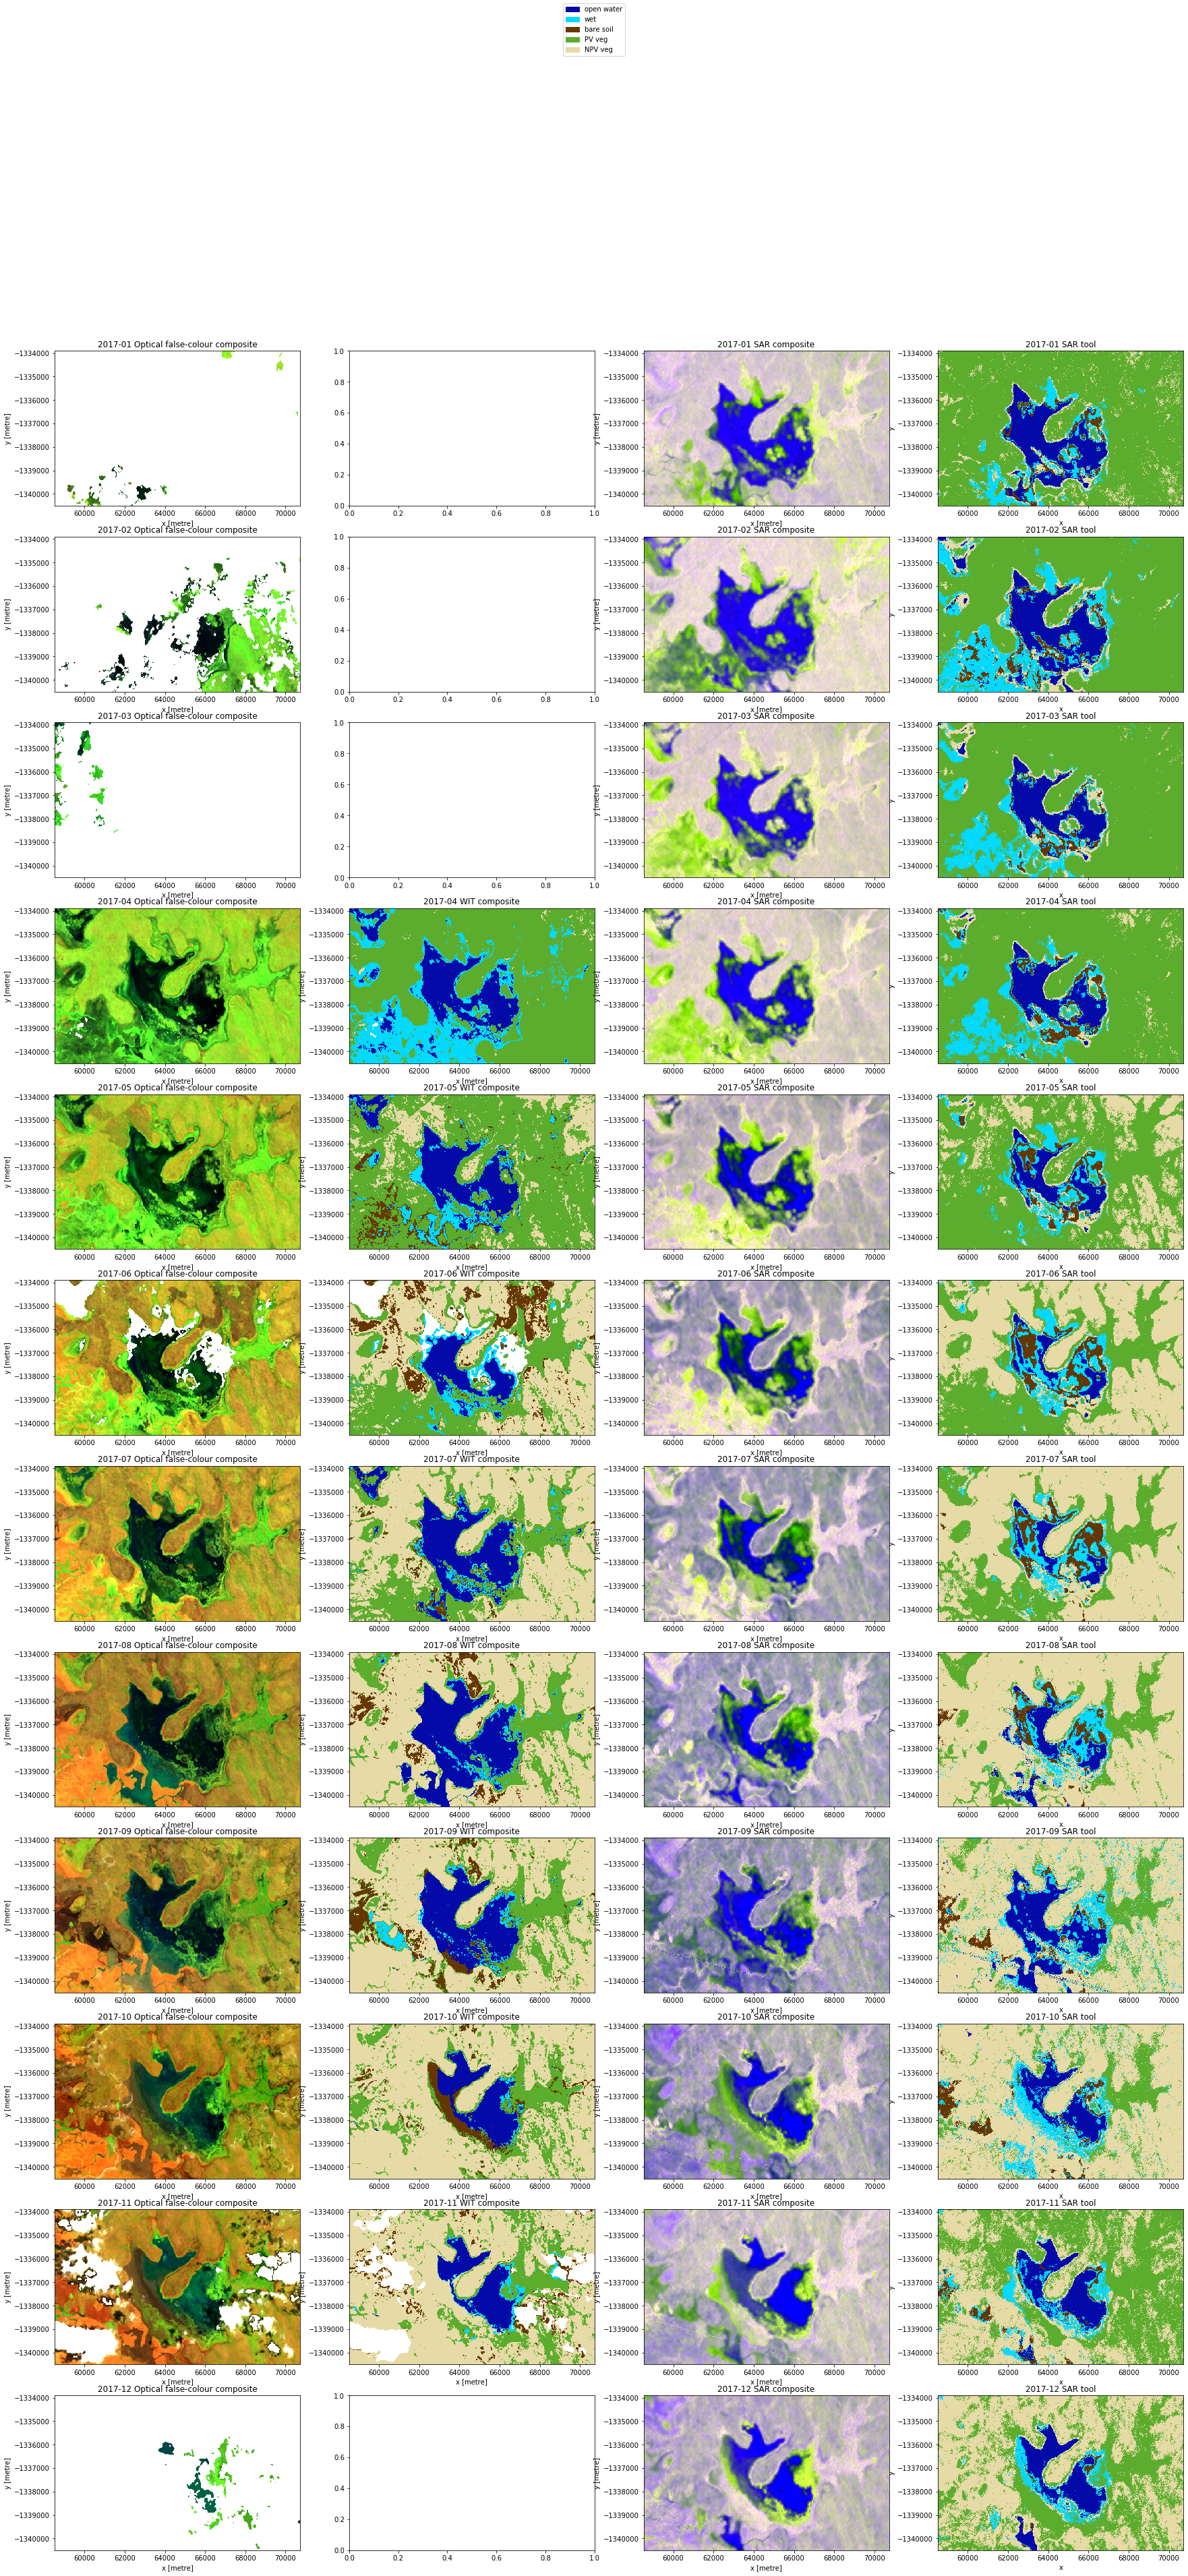

In [35]:
#make sure these values are correct if you want to study a different region

lat = (-12.70,-12.64)
long = (132.53,132.64)


#set up color palettes
pal_opt = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["brown"],  
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"]]

pal_rad = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"], 
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]
          ]


fig,ax = plt.subplots(12,4,figsize=(30,60))

import DEADataHandling

import fastmode
import wetlands_insight

imp.reload(fastmode)

for month in range(1,13):
    first = str(2017+(month-1)//12)+'-'+'{:02d}'.format((month-1)%12+1)+'-01'
    last = str(2017+month//12)+'-'+'{:02d}'.format(month%12+1)+'-01'

    query = {
        'lat': lat,
        'long': long,
        'time': (first,last)
    }
    
    
    #get optical false colour for the month
    opt_month = DEADataHandling.load_clearlandsat(dcO, query)
    if len(opt_month.green)>0:
        opt_mean = opt_month.mean(dim='time')
        DEAPlotting.rgb(opt_mean,bands=['swir1','nir','green'],ax=ax[month-1,0],size=None,robust=True)
        ax[month-1,0].title.set_text(first[:-3]+' Optical false-colour composite')

    
    #get the optical WIT maps for the month
    coverclasses = wetlands_insight.WIT_da(query)
    
    if len(coverclasses)>0:
        comp = wit_composite(coverclasses)
        if comp is not None:
            comp.plot(ax=ax[month-1,1],vmin=0,vmax=4.01,levels=6,colors=pal_opt,label=None,add_colorbar=False)
            ax[month-1,1].title.set_text(first[:-3]+' WIT composite')
            
    #calls to gc and del help with avoiding OOM errors
    
    #use this if you want to go back to per-scene preprocessing
    #sar_ds = load_cleaned_SAR(query)
    
    bulksar_ds = bulknormSAR.sel(time=slice(first,last))
    
    predicted_sar = cover_out.sel(time=slice(first,last))
    
    monthly_classes = predicted_sar.reduce(fastmode.mode_class,dim='time',num_classes = 5)
    
    compSAR = SAR_composite(bulksar_ds)
    
    
    DEAPlotting.rgb(compSAR,bands=['vh','vv','vh_over_vv'],ax=ax[month-1,2],size=None,robust=True)
    ax[month-1,2].title.set_text(first[:-3]+' SAR composite')
    
    plt.sca(ax[month-1,3])
    
    monthly_classes.plot(add_colorbar=False,colors=pal_rad,vmin=0,vmax=4.01,levels=6)
    ax[month-1,3].title.set_text(first[:-3]+' SAR tool')
    

from matplotlib.patches import Patch
labels = ['open water', 'wet','bare soil', 'PV veg', 'NPV veg']
leg_elements = [Patch(facecolor = pal_opt[i], edgecolor = pal_opt[i], label = labels[i]) for i in range(len(labels))]

fig.legend(handles = leg_elements, loc = 'upper center')

In [12]:
def norm_SAR_ds(sar_ds):
    #normalise each scene between 0 and 1
    normlogSAR = sar_ds.copy(deep=True)

    def normalise(nscene):
        nscene['vv'] = (nscene['vv']-nscene['vv'].median())/(2*nscene['vv'].std())
        nscene['vh'] = (nscene['vh']-nscene['vh'].median())/(2*nscene['vh'].std())
        nscene['vh_over_vv'] = (nscene['vh_over_vv']-nscene['vh_over_vv'].median())/(2*nscene['vh_over_vv'].std())
        
        return nscene
    
    try:
        for tind in range(len(normlogSAR.time)):
            nscene = normlogSAR.isel(time=tind)
            
            nscene = normalise(nscene)
            
            normlogSAR.vv[tind] = nscene.vv
            normlogSAR.vh[tind] = nscene.vh
            normlogSAR.vh_over_vv[tind] = nscene.vh_over_vv
            
    except AttributeError:
        normlogSAR = normalise(normlogSAR)
        
    return normlogSAR

In [5]:
allSAR

<xarray.Dataset>
Dimensions:     (time: 131, x: 488, y: 264)
Coordinates:
  * y           (y) float64 -1.34e+06 -1.34e+06 ... -1.334e+06 -1.334e+06
  * x           (x) float64 5.854e+04 5.856e+04 ... 7.069e+04 7.071e+04
  * time        (time) datetime64[ns] 2016-09-28T20:47:53.975363 ... 2018-12-29T20:48:23.024455
Data variables:
    vh          (time, y, x) float32 0.008764084 0.008907151 ... 0.03920173
    vv          (time, y, x) float32 0.047691338 0.04460837 ... 0.117370546
    vh_over_vv  (time, y, x) float32 0.1837668 0.19967444 ... 0.33399972

In [6]:
def bulknorm_SAR_ds(sar_ds):
    #normalise each scene between 0 and 1
    nscene = sar_ds.copy(deep=True)

    nscene['vv'] = (nscene['vv']-nscene['vv'].median())/(2*nscene['vv'].std())
    nscene['vh'] = (nscene['vh']-nscene['vh'].median())/(2*nscene['vh'].std())
    nscene['vh_over_vv'] = (nscene['vh_over_vv']-nscene['vh_over_vv'].median())/(2*nscene['vh_over_vv'].std())
        
    return nscene


In [8]:
bulknormSAR = bulknorm_SAR_ds(logSAR)

In [5]:
query = {'lat': (-12.7, -12.64),
 'long': (132.53, 132.64),
 'time': ('2016-09-01', '2019-01-01')}

allSAR = rf.load_cleaned_SAR(query,dc)

In [125]:
query = {'lat': (-12.7, -12.64),
 'long': (132.53, 132.64),
 'time': ('2016-09-01', '2019-01-01')}

In [6]:
logSAR = np.log(allSAR)

In [71]:
#save scaling factors for reuse on large dataset
mu = {'vv':logSAR.vv.median(),'vh':logSAR.vh.median(),'vh_over_vv':logSAR.vh_over_vv.median()}
sigma = {'vv':2*logSAR.vv.std(),'vh':2*logSAR.vh.std(),'vh_over_vv':2*logSAR.vh_over_vv.std()}
scaling_dict = {'mu':mu,'sigma':sigma}

In [7]:
imp.reload(rf)
bulknormSAR = rf.bulknorm_SAR_ds(logSAR)

In [100]:
bulknormSAR.vh_over_vv.min()

<xarray.DataArray 'vh_over_vv' ()>
array(-10.44351)

In [102]:
with open('mamukala_scaling_factors.pkl','wb') as f: pickle.dump(scaling_dict,f)

In [103]:
mu

{'vv': <xarray.DataArray 'vv' ()>
 array(-2.290612), 'vh': <xarray.DataArray 'vh' ()>
 array(-3.672697), 'vh_over_vv': <xarray.DataArray 'vh_over_vv' ()>
 array(-1.349034)}

In [64]:
logSAR.vh.mean()

<xarray.DataArray 'vh' ()>
array(-3.84051, dtype=float32)

In [66]:
logSAR.vh_over_vv.mean()

<xarray.DataArray 'vh_over_vv' ()>
array(-1.385806, dtype=float32)

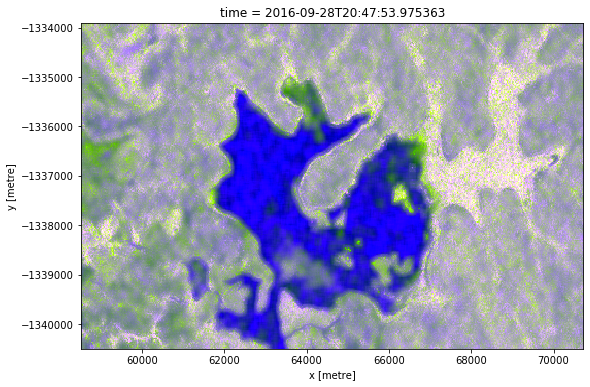

In [92]:
DEAPlotting.rgb(bulknormSAR.isel(time=0),bands=['vh','vv','vh_over_vv'])

In [9]:
#normalise each scene between 0 and 1
downsampled = rf.downsample_ds(bulknormSAR)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
#spatially resample that shit
def downsample_ds(normlogSAR):
    downsampled = normlogSAR.groupby_bins('x',len(normlogSAR.x)/5).mean(dim='x').groupby_bins('y',len(normlogSAR.y)/5).mean(dim='y')
    downsampled = downsampled.rename({'x_bins':'x','y_bins':'y'})
    return downsampled

In [4]:
import imp
imp.reload(rg)

<module 'radar_gmm' from '/g/data1a/r78/rlt118/dea-notebooks/radar_gmm.py'>

In [20]:
ktree = rg.SAR_Ktree()
ktree.fit(downsampled)

In [25]:
#save the classes so we can use this one for predicting in the future
ktree.landcover_dict = [2,2,3,4,3,1,1,0,0]

In [56]:
import pickle
with open("mamukala_full_fit.pkl","wb") as f: pickle.dump(ktree,f)

In [14]:
downsampled.vv.shape

(52, 97, 131)

In [21]:
all_out = ktree.predict_dataset(bulknormSAR)

In [26]:
cover_out = ktree.predict_dataset(bulknormSAR)

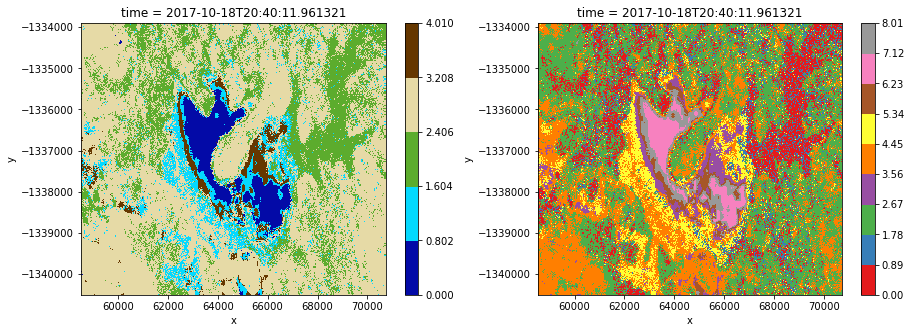

In [31]:
import seaborn as sns
pal = [
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]
       ]
tind=57
fig,ax = plt.subplots(1,2,figsize=(15,5))
cover_out.isel(time=tind).plot(vmin=0,vmax=4.01,levels=6,colors=pal,ax=ax[0])
all_out.isel(time=tind).plot(vmin=0,vmax=8.01,levels=10,cmap='Set1',ax=ax[1])

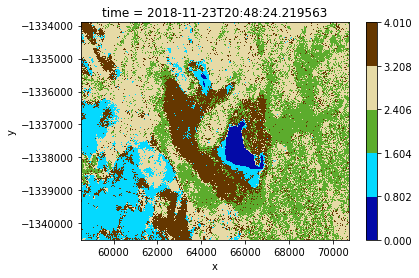

In [137]:
import seaborn as sns

pal_rad = [
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]
       ]

scene = bulknormSAR.isel(time=-7)

prediction = rg.calc_gmm_classes(scene,kmm)
baresoil_subkmm(prediction,scene,subkmm)

prediction.plot(vmin=0,vmax=4.01,levels=6,colors=pal_rad)


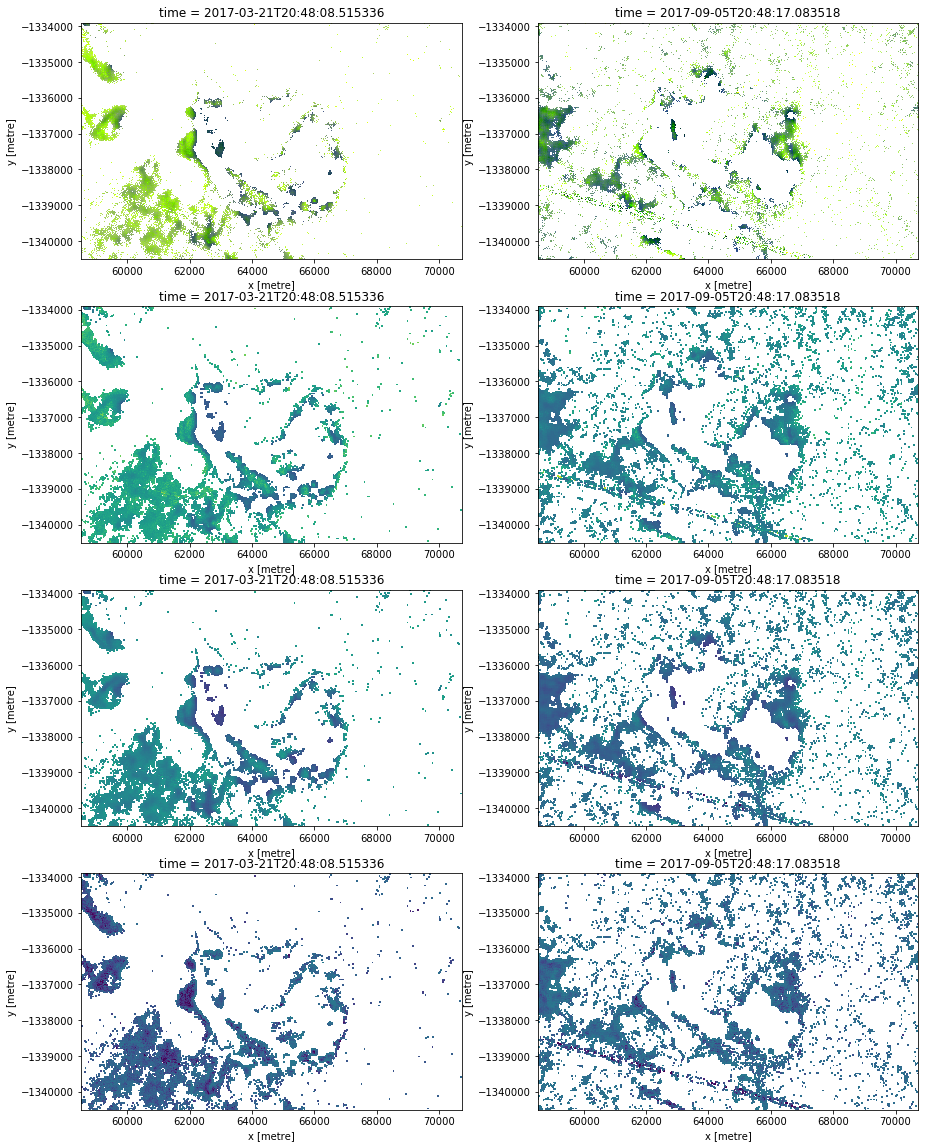

In [103]:
ind1 = 30
ind2 = 55
fig,ax=plt.subplots(4,2,figsize=(15,20))

class_ind1 = rg.calc_gmm_classes(bulknormSAR.isel(time=ind1),kmm)
class_ind2 = rg.calc_gmm_classes(bulknormSAR.isel(time=ind2),kmm)

scene1 = bulknormSAR.isel(time=ind1).where(class_ind1==1)
scene2 = bulknormSAR.isel(time=ind2).where(class_ind2==1)

DEAPlotting.rgb(scene1,bands=['vh','vv','vh_over_vv'],ax=ax[0,0],size=None,robust=True)
scene1.vv.plot(ax=ax[1,0],vmin=-2,vmax=2,add_colorbar=False)
scene1.vh.plot(ax=ax[2,0],vmin=-2,vmax=2,add_colorbar=False)
scene1.vh_over_vv.plot(ax=ax[3,0],vmin=-2,vmax=2,add_colorbar=False)

DEAPlotting.rgb(scene2,bands=['vh','vv','vh_over_vv'],ax=ax[0,1],size=None,robust=True)
scene2.vv.plot(ax=ax[1,1],vmin=-2,vmax=2,add_colorbar=False)
scene2.vh.plot(ax=ax[2,1],vmin=-2,vmax=2,add_colorbar=False)
scene2.vh_over_vv.plot(ax=ax[3,1],vmin=-2,vmax=2,add_colorbar=False)

It is clear that 'dry' areas are darker than 'wet' areas, but both are in class 1 according to the KMeans classifier. The following histograms suggest that thresholding on VV as a post-processing step on the KMeans predictions could be a promising improvement to the cover classifier

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        7.000e+00, 1.600e+01, 6.700e+01, 1.820e+02, 2.900e+02, 9.830e+02,
        2.136e+03, 2.075e+03, 2.081e+03, 1.911e+03, 1.919e+03, 1.407e+03,
        7.270e+02, 3.150e+02, 1.490e+02, 3.800e+01, 4.000e+00, 7.000e+00]),
 array([-2.8697615 , -2.76046961, -2.65117772, -2.54188584, -2.43259395,
        -2.32330206, -2.21401017, -2.10471829, -1.9954264 , -1.88613451,
        -1.77684263, -1.66755074, -1.55825885, -1.44896697, -1.33967508,
        -1.23038319, -1.1210913 , -1.01179942, -0.90250753, -0.79321564,
        -0.68392376, -0.57463187, -0.46533998, -0.3560481 , -0.24675621,
        -0.13746432, -0.02817243,  0.08111945,  0.19041134,  0.29970323,
         0.40899511]),
 <a list of 30 Patch objects>)

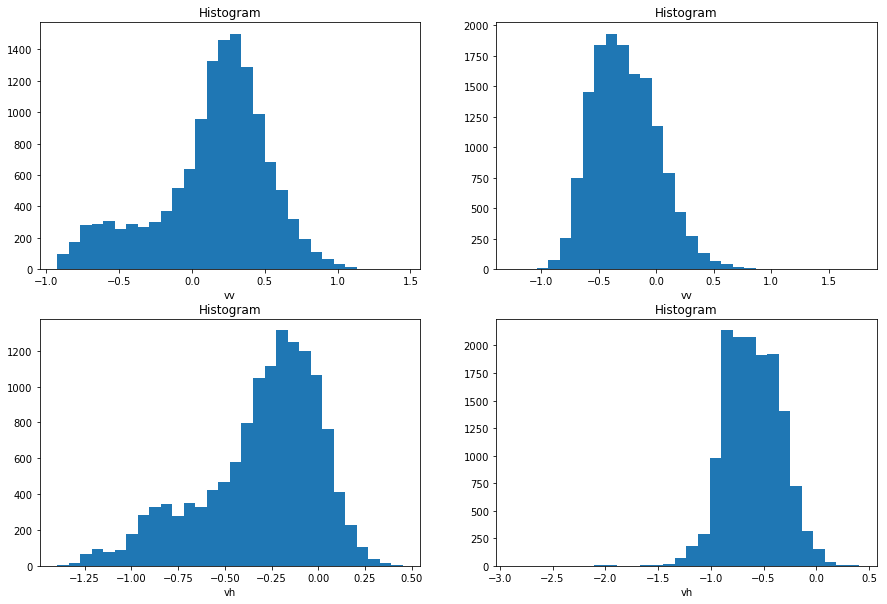

In [59]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

scene1.vv.plot.hist(ax=ax[0,0],bins=30)
scene1.vh.plot.hist(ax=ax[1,0],bins=30)

scene2.vv.plot.hist(ax=ax[0,1],bins=30)
scene2.vh.plot.hist(ax=ax[1,1],bins=30)

In [95]:
def baresoil_postprocess(kmeans_classes, sar_scene, wet_class = 1, thresh=-0.25):
    """introduces a manually-thresholded 'bare soil' class. This code assumes
    that the 'wet' class from the classifier is 1, so make sure the classes are
    ordered correctly before applying this postprocessing step, or pass the actual
    bare soil class as a keyword argument. Acts in-place on the KMM class array
    """
    
    wetbare = (kmeans_classes == 1)
    dark = (sar_scene.vv < thresh)
    
    baresoil = np.logical_and(wetbare,dark)
    
    #paint the bare soil class
    np.place(kmeans_classes.data,baresoil.data,4)
    
def baresoil_subkmm(kmeans_classes, sar_scene, subkmm, wet_class = 1, bare_class = 1):
    """Applies a second K-means model based on the output of the first to differentiate
    bare soil and 'wet' (flooded) areas. Acts in place on the original KMM class predictions
    """
    
    wetbare = (kmeans_classes == 1)
    
    wetbare_da = sar_scene.where(kmeans_classes == 1)
    
    subclasses = rg.gmm_dataset(wetbare_da,subkmm)
    
    baresoil = np.logical_and(wetbare, subclasses==bare_class)
    
    #paint the bare soil class
    np.place(kmeans_classes.data,baresoil.data,4)

In [104]:
imp.reload(rg)
baresoil_subkmm(class_ind2,scene2,subkmm)

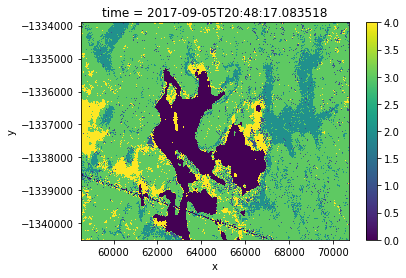

In [105]:
class_ind2.plot()

In [60]:
if(np.nan):
    print(1)

1


In [215]:
kmm.cluster_centers_

array([[-3.4762611 , -1.0345552 , -2.441706  ],
       [-2.3646548 , -2.0948005 , -0.26985586],
       [-5.3083496 , -3.8743017 , -1.4340549 ],
       [-3.7460217 , -2.2832475 , -1.4627746 ]], dtype=float32)

In [164]:
kmm.cluster_centers_

array([[0.24096209, 0.33829462, 0.54083899],
       [0.60048049, 0.60526517, 0.60933415],
       [0.5639573 , 0.77465167, 0.36820166],
       [0.79965918, 0.61697211, 0.80715589]])

In [169]:
res_naf

array([[0.        , 0.        , 0.        ],
       [0.07515052, 0.24080311, 0.48597622],
       [0.09188397, 0.16355253, 0.59602883],
       ...,
       [0.96679898, 0.78855658, 0.77997001],
       [0.99718922, 0.7073953 , 0.90921551],
       [1.        , 0.74167626, 0.87126348]])

In [15]:
downsampled = downsample_ds(bulknormSAR)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [26]:
kmm = rg.fit_kmeans(downsampled,n_components=4)
gmm = rg.fit_gmm(downsampled,n_components=4)

In [90]:
all_predictions = rg.gmm_dataset(downsampled,kmm)

In [91]:
subk_input = downsampled.where(all_predictions==1)

In [107]:
subkmm = rg.fit_kmeans(subk_input,n_components=2)
subgmm = rg.fit_gmm(subk_input,n_components=2)

In [94]:
subkmm.cluster_centers_

array([[ 0.2747349 , -0.25393901, -1.0364281 ],
       [-0.42383478, -0.81989728, -0.80490856]])

In [108]:
subgmm.means_

array([[-0.06709889, -0.67237999, -1.19292918],
       [-0.09549902, -0.45458254, -0.72437764]])

In [676]:
kmm.cluster_centers_

array([[ 0.15651776,  0.22052519,  0.10995691],
       [-0.55765605, -0.73552096, -0.3742675 ],
       [ 0.2670769 , -0.12992586, -0.6996376 ],
       [-1.3929743 , -1.1639918 ,  0.5378014 ]], dtype=float32)

## Making another stack plot with the new 'best model' (predicting on normalised downsampled and/or segmented data)

In [29]:
kmm.cluster_centers_ = kmm.cluster_centers_[[1,3,2,0]]

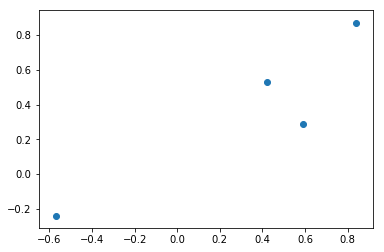

In [649]:
plt.scatter(kmm.cluster_centers_[:,0],kmm.cluster_centers_[:,1])

Now let's make the stack plot and compare the SAR classes to the WIT ones over time.

In [326]:
#calc the timeseries with the new KMM clusters
pool = mp.Pool(mp.cpu_count())

index_stops = np.linspace(0,len(downsampled.time),num=mp.cpu_count()+1,dtype=int)

results = [pool.apply_async(rg.calc_gmm_timeseries,args=(downsampled,kmm),kwds={'tmin':index_stops[i],'tmax':index_stops[i+1]}) for i in range(len(index_stops) - 1)]

pool.close()
pool.join()

res_a = [r.get() for r in results]

t = xr.concat([res[0] for res in res_a],dim='time')
ts = np.concatenate(tuple(res[1] for res in res_a))

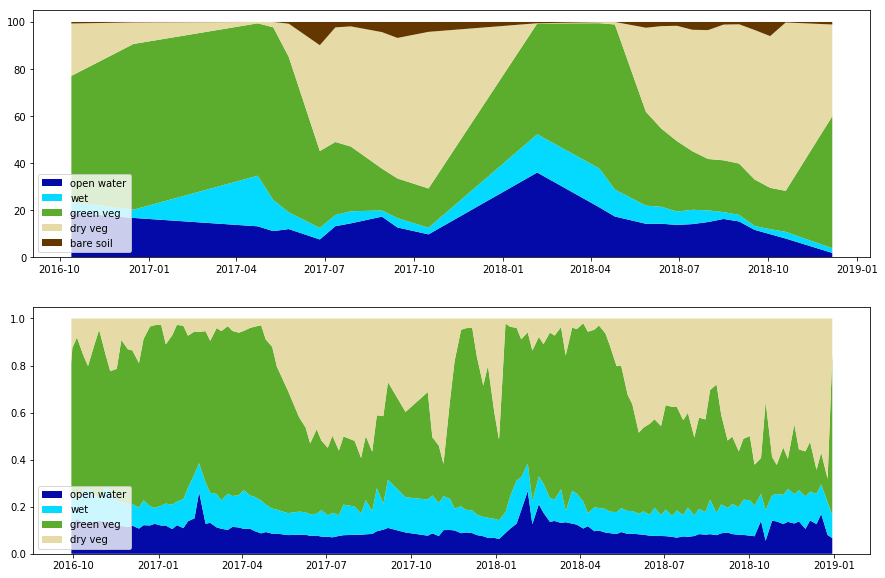

In [327]:
#the optical data covers a longer time period than the SAR so let's truncate it
wit_arr = wit_arr.sel(time=slice(t[0],t[-1]))

fig,ax = plt.subplots(2,1,figsize=(15,10))

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

plt.sca(ax[0])
plt.stackplot(wit_arr.time.data,wit_arr.to_array().data,labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal)

plt.legend(loc='lower left')

plt.sca(ax[1])
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"]]
plt.stackplot(t.data,ts.transpose(),labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg'
                     ], colors=pal)

plt.legend(loc='lower left')

In [632]:
perpix_ds = perpixnorm(logSAR)

In [633]:
perpix_ds.vh**2 + perpix_ds.vv**2 + perpix_ds.vh_over_vv**2

<xarray.DataArray (time: 131, y: 264, x: 488)>
array([[[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       ...,

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]],

       [[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]]], dtype=float32)
Coordinates:
  * y        (y) float64 -1.34e+06 -1.34e+06 -1.34e+06 ... -1.334e+06 -1.334e+06
  * x        (x) float64 5.854e+04 5.856e+04 5.859e+04 ... 7.069e+04 7.071e+04
  * time     (time) datetime64[ns] 2016-09-28T20:47:53.975363 ... 2018-12-29T20:48:23.024455

## Debugging the dry season

In [666]:
query = {'lat': (-12.7, -12.64),
 'long': (132.53, 132.64),
 'time': ('2016-09-01', '2017-10-01')}

In [76]:
downsampled.vv.nbytes

5286112

In [68]:
allSAR.vv.shape

(131, 264, 488)

In [667]:
worst_sar_ds = load_cleaned_SAR(query)

In [668]:
badnorm = norm_SAR_ds(worst_sar_ds)

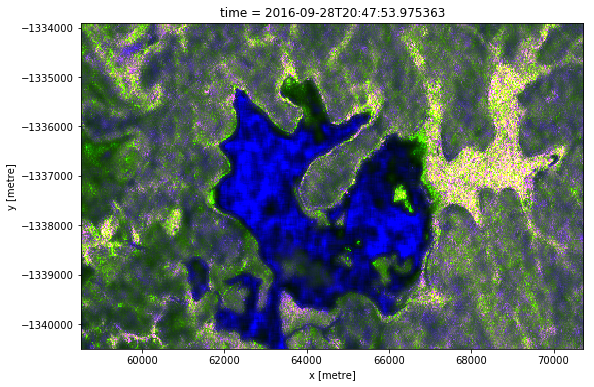

In [671]:
DEAPlotting.rgb(badnorm.isel(time=0),bands=['vh','vv','vh_over_vv'])

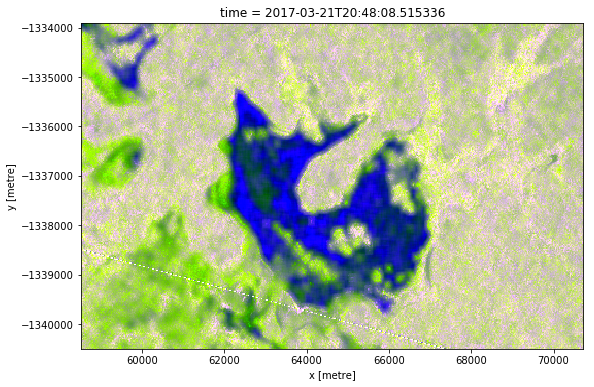

In [672]:
DEAPlotting.rgb(normlogSAR.isel(time=30),bands=['vh','vv','vh_over_vv'])

In [40]:
#tree timeseries
t=landcover_out.time
ts = np.array([(landcover_out==val).sum(dim=['x','y']) for val in range(5)])

In [44]:
ts = ts/np.sum(ts,axis=0)

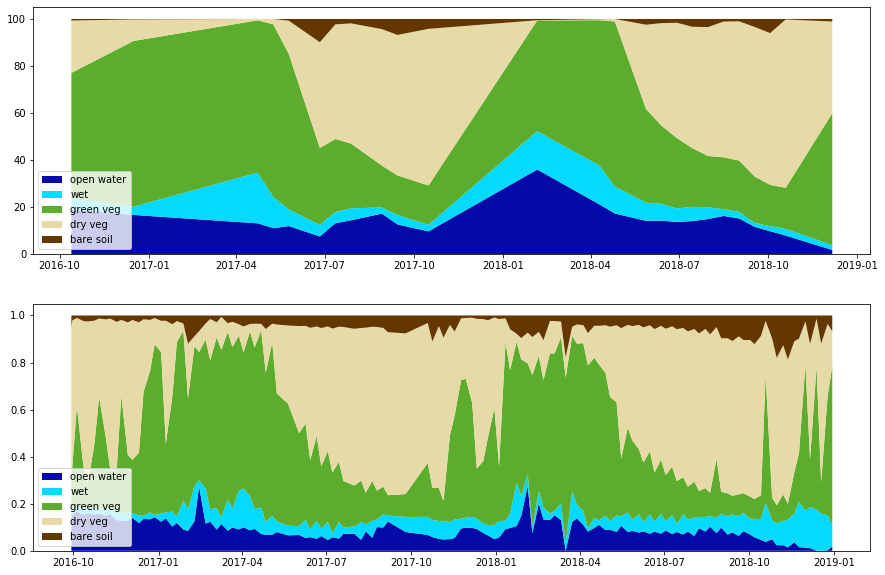

In [49]:
#the optical data covers a longer time period than the SAR so let's truncate it
wit_arr = wit_arr.sel(time=slice(t[0],t[-1]))

fig,ax = plt.subplots(2,1,figsize=(15,10))

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

plt.sca(ax[0])
plt.stackplot(wit_arr.time.data,wit_arr.to_array().data,labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal)

plt.legend(loc='lower left')

plt.sca(ax[1])
plt.stackplot(t.data,ts,labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil'
                     ], colors=pal)

plt.legend(loc='lower left')